# Emergency Warning Satellite Service (EWSS) Demonstration


In [1]:
%cd cssrlib-data/samples

c:\work\gps\cssrlib\tutorials\cssrlib-data\samples


In [2]:
from binascii import unhexlify
import numpy as np
import bitstruct as bs
from cssrlib.gnss import time2doy, epoch2time, gpst2time
from cssrlib.ewss import jmaDec, camfDec
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt

In [3]:
ep = [2025, 8, 21, 7, 0, 0]
time = epoch2time(ep)
year = ep[0]
doy = int(time2doy(time))

In [4]:
cs = jmaDec()
cs.monlevel = 0
cs.time = time

csx = camfDec()
csx.monlevel = 2
csx.time = time

In [ ]:
file_sbas = '../data/doy2025-233/233h_sbas.txt'
dtype = [('wn', 'int'), ('tow', 'float'), ('prn', 'int'),
                 ('type', 'int'), ('marker', 'S2'), ('nav', 'S124')]
v = np.genfromtxt(file_sbas, dtype=dtype)
tow = np.unique(v['tow'])

## Parsing DCR

In [50]:
def parse_dcr(vi_dcr, cs, params=[], pos=None):
    if len(vi_dcr) == 0:
        return params, pos
    for vi_ in vi_dcr:
        cs.time = gpst2time(vi_['wn'], vi_['tow'])
        dcr = unhexlify(vi_['nav'])
        cs.decode(dcr, 14)
        print(cs.gen_msg(cs.dc))

        if cs.dc == 10: # DCR Typhoon
            pos = cs.pos if pos is None else np.vstack([pos, cs.pos])
            params.append(cs.params)

    return params, pos


In [52]:
params = []
pos = None

prn_ref = 199
nep = 300

for ne in range(nep):
    vi = v[(v['tow'] == tow[ne]) & (v['prn'] == prn_ref)]

    vi_dcr = vi[vi['type'] == 43]  # DCR
    params, pos = parse_dcr(vi_dcr, cs, params, pos)

Typhoon (Issue)
 report time: 2025-08-21 06:50:00
 typhoon #12
 reference time: 2025-08-21 12:00:00
 reference type: Forecast
 elapsed time: 6h
 lat/lon: 31.5833/130.1667
 central pressure: 1002 hPa
 maximum wind: 18 m/s
 maximum instant wind: 25 m/s





Typhoon (Issue)
 report time: 2025-08-21 06:50:00
 typhoon #12
 reference time: 2025-08-21 15:00:00
 reference type: Forecast
 elapsed time: 9h
 lat/lon: 31.5833/130.4167
 central pressure: 1004 hPa
 maximum wind: 18 m/s
 maximum instant wind: 25 m/s





Typhoon (Issue)
 report time: 2025-08-21 06:50:00
 typhoon #12
 reference time: 2025-08-21 18:00:00
 reference type: Forecast
 elapsed time: 12h
 lat/lon: 31.5833/130.6667
 central pressure: 1004 hPa
 maximum wind: 18 m/s
 maximum instant wind: 25 m/s





Typhoon (Issue)
 report time: 2025-08-21 06:50:00
 typhoon #12
 reference time: 2025-08-21 21:00:00
 reference type: Forecast
 elapsed time: 15h
 lat/lon: 31.8333/131.0000
 central pressure: 1004 hPa
 maximum wind: 18 m/s
 maximum 

## Parsing CAMF in DCX

In [43]:
def parse_dcx(vi_dcx, csx):
    if len(vi_dcx) == 0:
        return
    for vi_ in vi_dcx:
        csx.time = gpst2time(vi_['wn'], vi_['tow'])
        buff = unhexlify(vi_['nav'])

        sdmt, sdm = bs.unpack_from('u1u9', buff, 14)
        # print(f"sdmt={sdmt} sdm={sdm:0b}")
        csx.decode(buff, 24)  # decode CAMF message
        csx.decode_ext(buff, 24+122)  # decode extended message

In [44]:
for ne in range(nep):
        vi = v[(v['tow'] == tow[ne]) & (v['prn'] == prn_ref)]
        vi_dcx = vi[vi['type'] == 44]  # DCX
        parse_dcx(vi_dcx, csx)

[DCX-ext] pid=1 2025-08-21 07:00:59 熊本県上益城郡益城町 Leave the additional target area range. -90.0 45.0 0.216 0.216 -90.0 1
[DCX-ext] pid=1 2025-08-21 07:01:03 熊本県上益城郡益城町 Leave the additional target area range. -90.0 45.0 0.216 0.216 -90.0 1
[DCX] 2025-08-21 07:00:00 hcat=82 subj=0 pid=1 moderate MET - Tropical cyclone (typhoon) inst=0 info=0 (not specified) (not specified) 
[DCX-ext] pid=1 2025-08-21 07:01:11 鹿児島県南九州市 Leave the additional target area range. -90.0 45.0 0.216 0.216 -90.0 1
[DCX] 2025-08-21 07:00:00 hcat=82 subj=0 pid=1 moderate MET - Tropical cyclone (typhoon) inst=0 info=0 (not specified) (not specified) 
[DCX-ext] pid=1 2025-08-21 07:01:15 鹿児島県南九州市 Leave the additional target area range. -90.0 45.0 0.216 0.216 -90.0 1
[DCX] 2025-08-21 07:01:00 hcat=82 subj=0 pid=1 severe MET - Tropical cyclone (typhoon) inst=0 info=0 (not specified) (not specified) 
[DCX-ext] pid=1 2025-08-21 07:02:15 鹿児島県南九州市 Leave the additional target area range. -90.0 45.0 0.216 0.216 -90.0 1
[DCX] 2025

## Plot result

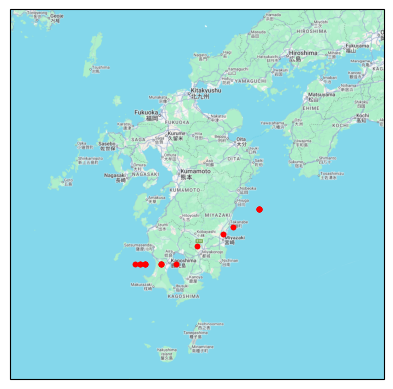

In [47]:
extent = [128, 134, 30, 35]  # kyusyu, Japan

fig = plt.figure()

stamen_terrain = cimgt.GoogleTiles()
ax = plt.axes(projection=stamen_terrain.crs)
ax.set_extent(extent)
ax.add_image(stamen_terrain, 8)

if pos is not None:
    sm = plt.plot(pos[:, 1], pos[:, 0], 'r.', transform=ccrs.PlateCarree())
plt.show()